# Animal Classifier: 🐔 vs 🐮

## Overview

### Data

- Chickens: 1980
- Cows: 2052
- Pretty balanced dataset - can add weights to loss to mimic sampling for perfectly balanced dataset
- Test split ratio: 0.2

#### Image Preprocessing 

- Resize images to dim
- Normalise
- Can add augmentation here later maybe

### Methodology

- Ideally would fine tune a model pretrained on ImageNet like resnet or vgg
- For simplicity, created basic CNN here using high level TfLearn 


### Evaluation

- Accuracy, precision, recall, f-score
- Loss


### Iteration

- Visualise mistakes to adapt and iterate on model and/or data
- Add custom learning metrics in Tensorboard: precision/recall/fscore
- Train model to find point of overfitting
- Add regularisation to prevent over/under fitting: dropout/weight decay/normalisation
- Fine tune model params: learning rate/batch size/layers/units


In [1]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.layers.conv import conv_2d, max_pool_2d
from sklearn.model_selection import train_test_split
from tflearn.layers.estimator import regression
from tflearn.metrics import Accuracy
from skimage.transform import resize
from IPython.display import Image
from tflearn import DNN
from skimage import io
from glob import glob
import numpy as np
import os

### Create Train/Test Data

- Test ratio: 0.2

In [2]:
def import_images(path, label, image_size):
    """
    Import images from path, resize image and assign label
    """
    image_files = glob(os.path.join(path, '*.jpg'))
    num_images = len(image_files)
    print("{} images: {}".format(path, len(image_files)))

    images = np.zeros((num_images, image_size, image_size, 3), dtype='float64')
    labels = np.zeros((num_images, 2), dtype='float64')
    count = 0

    for f in image_files:
        try:
            img = io.imread(f)
            new_img = resize(img, (image_size, image_size, 3))
            images[count] = np.array(new_img)
            labels[count] = label
            count += 1
        except:
            continue

    return images, labels

In [4]:
# Import images and assign labels
chicken_label = [0., 1.]
cow_label = [1., 0.]

chicken_x, chicken_y = import_images(path='../data/Chickens', label=chicken_label, image_size=64)
cow_x, cow_y = import_images(path='../data/Cows', label=cow_label, image_size=64)

../../data/Chickens images: 1976
../../data/Cows images: 2049


In [6]:
total_x = np.concatenate((chicken_x, cow_x))
total_y = np.concatenate((chicken_y, cow_y))
print("Total images: {}".format(len(total_x)))

# Shuffle data and create Train/Test split
train_x, test_x, train_y, test_y = train_test_split(total_x, total_y, test_size=0.2, shuffle=True)

print("Train X Data Shape: {}".format(train_x.shape))
print("Train Y Data Shape: {}".format(train_y.shape))
print("Test X Data Shape: {}".format(test_x.shape))
print("Test Y Data Shape: {}".format(test_y.shape))

Total images: 4025
Train X Data Shape: (3220, 64, 64, 3)
Train Y Data Shape: (3220, 2)
Test X Data Shape: (805, 64, 64, 3)
Test Y Data Shape: (805, 2)


### Train Model

```
Input -> Conv -> Pool -> Conv -> Pool ->  Conv -> Pool -> FullyConnected -> Dropout -> FullyConnected (Softmax)
```

- Adam optimiser
- learning_rate = 0.0001
- dropout_rate: 0.5


In [5]:
def cnn(image_size=64, keep_prob=0.5):
    """
    CNN

    Input -> Conv -> Pool -> Conv -> Pool ->  Conv -> Pool -> FullyConnected -> Dropout -> FullyConnected + Softmax
    """
    # Normalisation step
    prep = ImagePreprocessing()
    prep.add_featurewise_zero_center()
    prep.add_featurewise_stdnorm()

    # Can add image augmentation here
    out = input_data(shape=[None, image_size, image_size, 3],
                     data_preprocessing=prep,
                     name='input_data')

    # Conv 1 (32 3x3x3 filters)
    out = conv_2d(out, 32, 3, activation='relu', name='conv_1')

    # Max Pool
    out = max_pool_2d(out, 2)

    # Conv 2 (64 3x3x3 filters)
    out = conv_2d(out, 64, 3, activation='relu', name='conv_2')

    # Max Pool
    out = max_pool_2d(out, 2)

    # Conv 3 (64 3x3x3 filters)
    out = conv_2d(out, 64, 3, activation='relu', name='conv_3')

    # Max pool
    out = max_pool_2d(out, 2)

    # Fully Connected
    out = fully_connected(out, 512, activation='relu')

    # Dropout
    out = dropout(out, keep_prob=keep_prob)

    # Fully Connected
    out = fully_connected(out, 2, activation='softmax')

    return out

In [10]:
network = regression(incoming=cnn(image_size=64, keep_prob=0.5),
                     optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0001,
                     metric=Accuracy(name="Accuracy"))

model = DNN(network=network,
            max_checkpoints=10,
            checkpoint_path='../logs/',
            tensorboard_dir='../logs/')

In [11]:
model.fit(X_inputs=train_x, 
          Y_targets=train_y, 
          validation_set=(test_x, test_y), 
          batch_size=100,
          n_epoch=1000, 
          run_id='chicken_vs_cow.tflearn', 
          show_metric=True)

Training Step: 1417  | total loss: 0.05666 | time: 23.381s
| Adam | epoch: 043 | loss: 0.05666 - Accuracy: 0.9890 -- iter: 3100/3220


KeyboardInterrupt: 

### Notes

- Monitored Tensorboard and stopped training once model started to overfit 
- Optimal model at step ~800
- Loss: ~0.3
- Accuracy: ~0.87

##### Train vs Test Loss from Tensorboard Logs

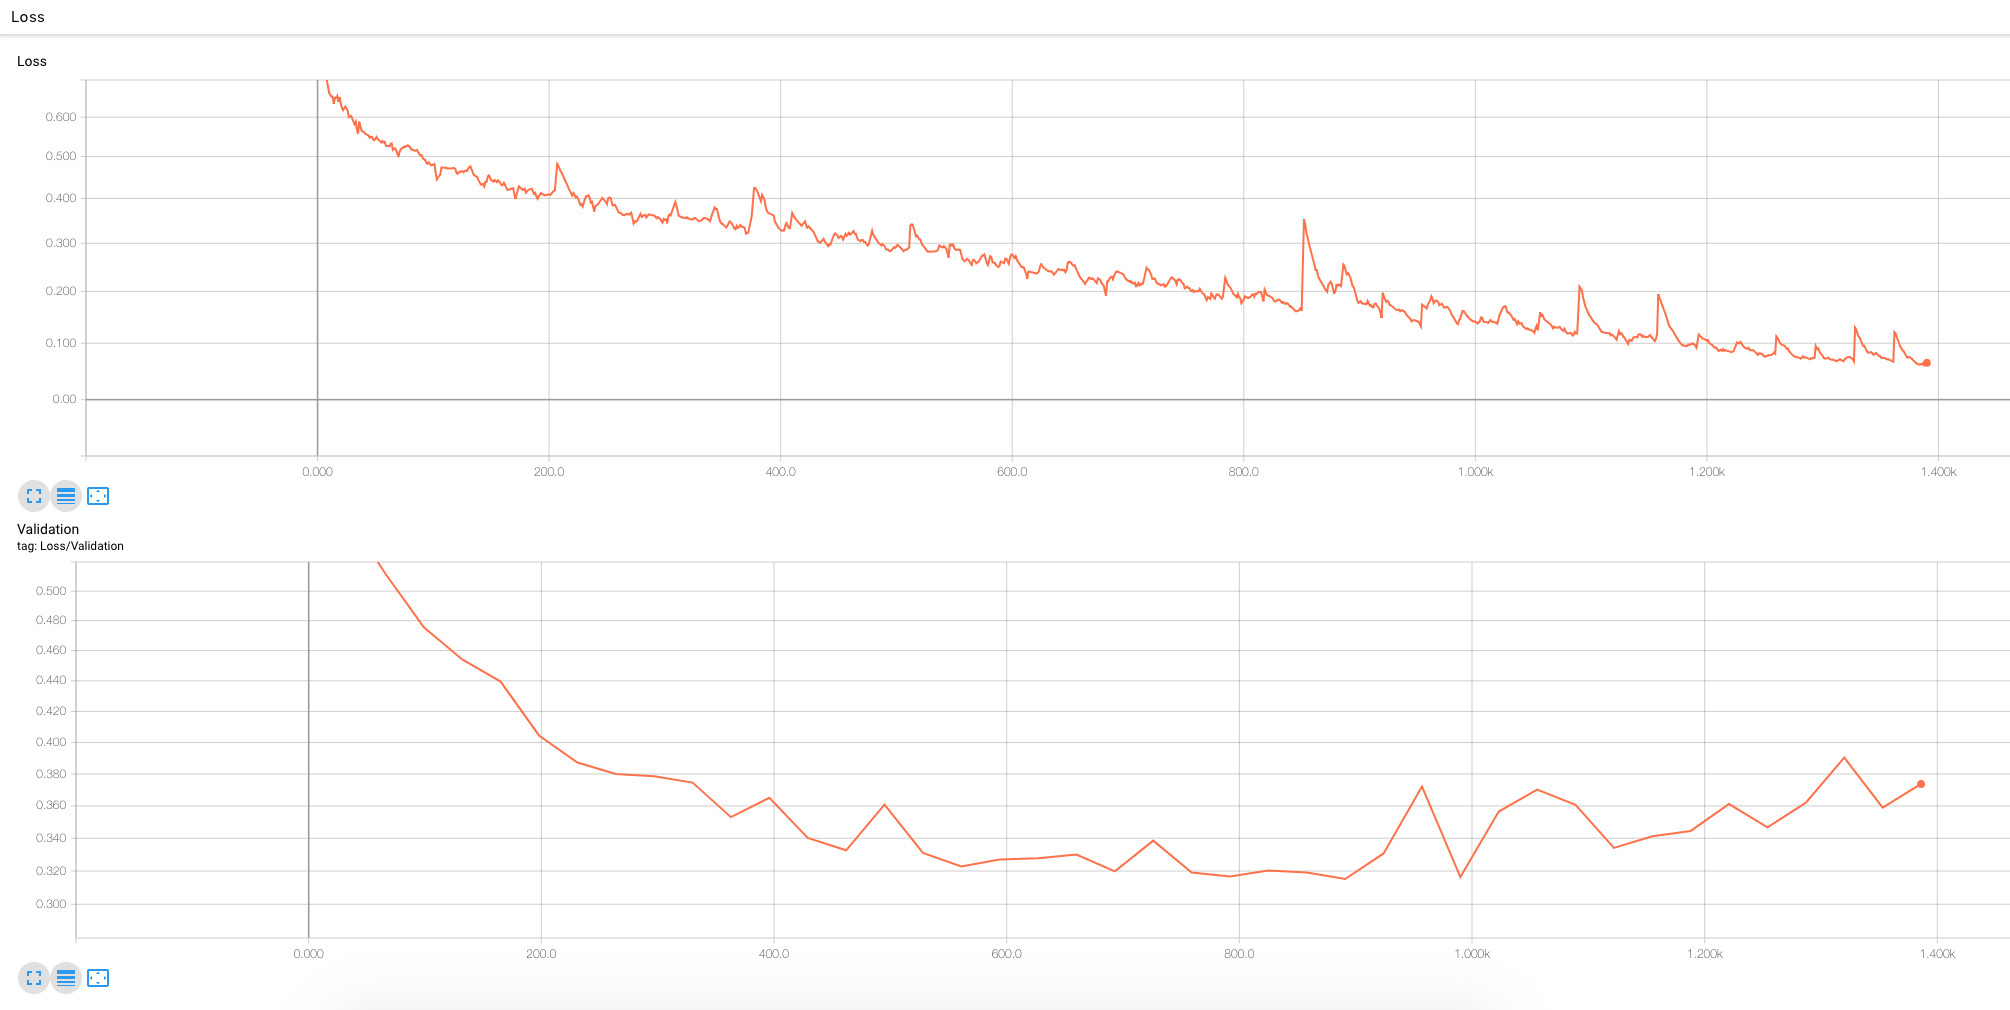

In [15]:
Image('../reports/tensorboard_loss.png')

#### Test Accuracy

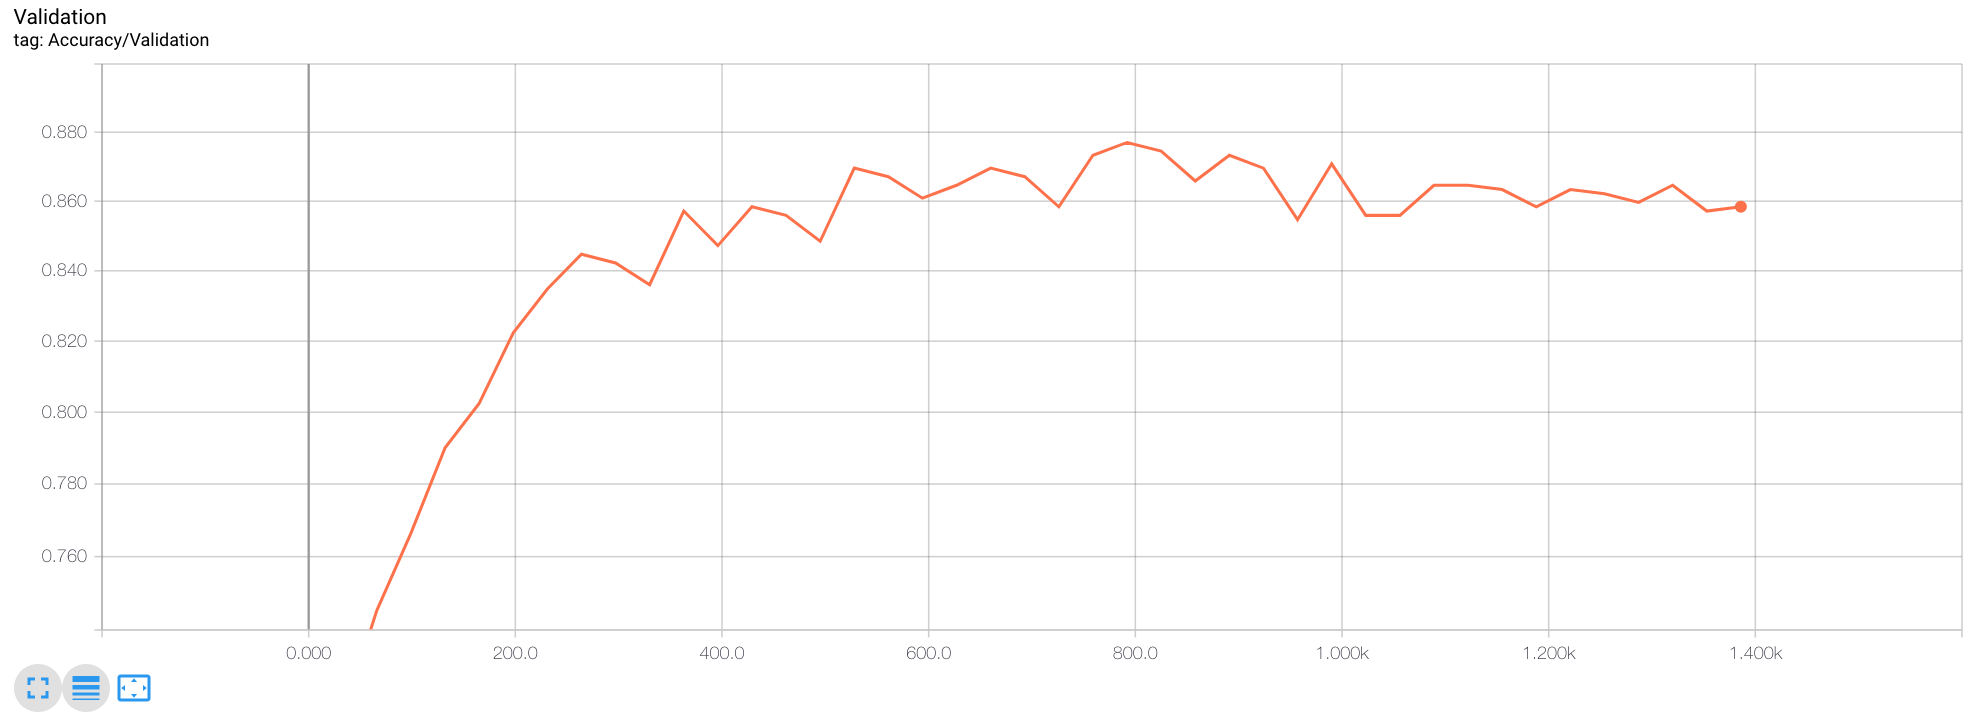

In [16]:
Image('../reports/tensorboard_accuracy.png')

### Next Steps

- Offline evaluation to inspect inaccuracies and determine precision/recall/fscore
- Re implement model using Tensorflow so easier to customise model, config and add custom metrics incl image summaries (add ability to add val and train metrics to one graph)
- Add more regularisation 
- Fine tune params